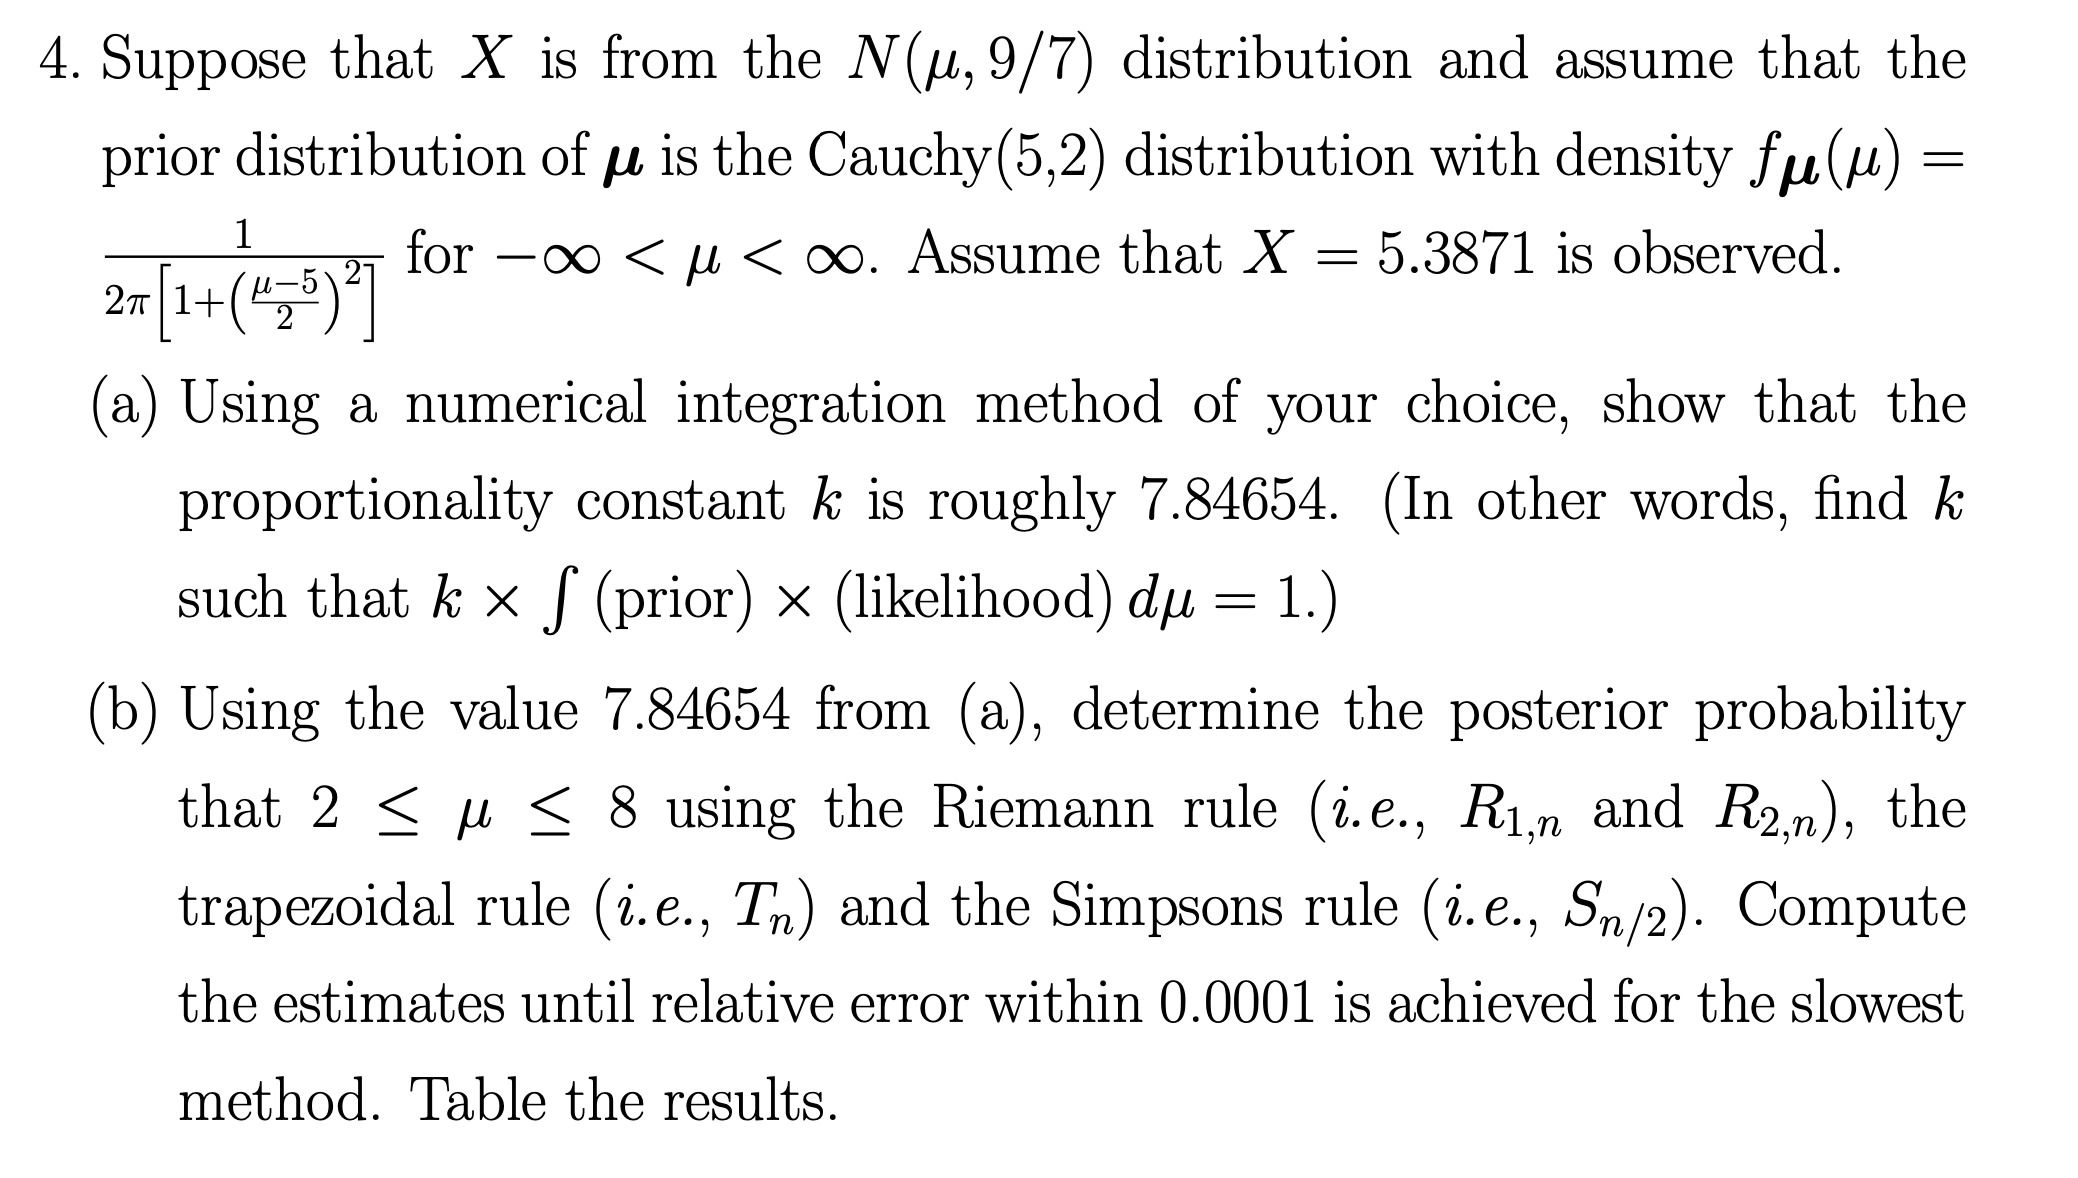

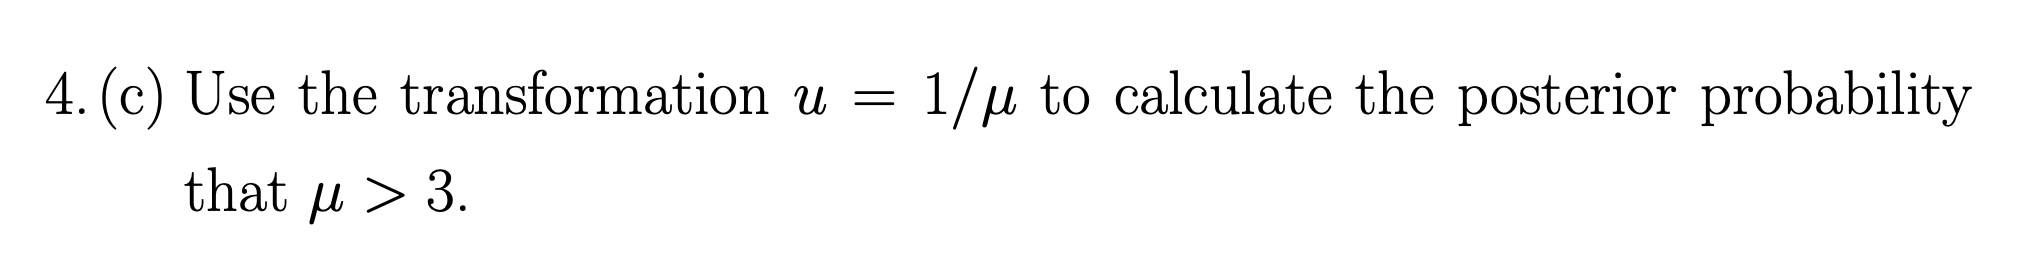

In [13]:
import math
import numpy as np

# -----------------------------
#  1. 先定义题目给出的常量与函数
# -----------------------------

# 观测到的 X
x_obs = 5.3871

# X ~ Normal(mu, 9/7)，方差=9/7，则标准差：
sigma2 = 9/7
sigma  = math.sqrt(sigma2)

# (a) 先定义先验:  prior(mu) = Cauchy(5, 2)
def prior(mu):
    # Cauchy(位置=5,尺度=2) 的密度公式:
    #  f(mu) = 1/( pi*2 ) * 1/[1 + ((mu-5)/2)^2]
    return 1/(math.pi*2) * 1.0/(1.0 + ((mu - 5)/2.0)**2)

# (b) 定义似然:  likelihood(mu) = NormalPDF(x=5.3871, mean=mu, variance=9/7)
def likelihood(mu):
    # N(mu, sigma^2)在 x_obs 处的密度
    z = (x_obs - mu)/sigma
    return (1.0/(math.sqrt(2*math.pi)*sigma)) * math.exp(-0.5*z*z)

# 未归一化的后验：  p*(mu) = prior(mu)*likelihood(mu)
def unnormalized_posterior(mu):
    return prior(mu)*likelihood(mu)

# -----------------------------
#  2. 实现 Simpson 数值积分(等距划分)
# -----------------------------
def simpson_integrate(func, a, b, n):
    """
    用Simpson公式在区间[a,b]上对func做数值积分。
    要求 n 为偶数。
    返回近似的 \int_a^b func(x) dx
    """
    if n % 2 != 0:
        raise ValueError("Simpson法则需要将区间分成偶数个子区间( n 必须是偶数 )。")
    
    h = (b - a)/n  # 步长
    x0 = a
    xN = b
    
    # f(x0) + f(xN)
    s = func(x0) + func(xN)
    
    # 依次加上系数4或2的项
    for k in range(1, n):
        xk = a + k*h
        # k为奇数时系数4，k为偶数时系数2
        if k % 2 == 1:
            s += 4*func(xk)
        else:
            s += 2*func(xk)
    
    return s * (h/3.0)

# -----------------------------
#  3. 计算归一化常数 k
# -----------------------------

# 由于是从 -∞ 到 ∞，我们用 [-M, M] 近似
M = 100.0  # 或更大, 如200, 以保证尾部贡献很小
# 为了精度，用较多的分段 n（偶数）
n_big = 20000

I_approx = simpson_integrate(unnormalized_posterior, -M, M, n_big)
k = 1.0 / I_approx

print(f"使用Simpson在[-{M},{M}]上积分的结果 ≈ {I_approx}")
print(f"因此归一化常数 k ≈ {k:.6f}")

使用Simpson在[-100.0,100.0]上积分的结果 ≈ 0.1274452199464019
因此归一化常数 k ≈ 7.846508


<>:35: SyntaxWarning: invalid escape sequence '\i'
<>:35: SyntaxWarning: invalid escape sequence '\i'
/var/folders/_v/z97dbq5n0msfsdk6k58jt2380000gn/T/ipykernel_6230/2499319370.py:35: SyntaxWarning: invalid escape sequence '\i'
  """


In [11]:
import math

# ------------------ 1. 给定题目中的参数/函数 ------------------
k = 7.84654  # (a)题已知的归一化常数
x_obs = 5.3871
sigma2 = 9/7
sigma  = math.sqrt(sigma2)

def prior(mu):
    # Cauchy(5,2)
    return 1/(math.pi*2) / (1 + ((mu - 5)/2.0)**2)

def likelihood(mu):
    # N(mu, 9/7)在 x_obs=5.3871 处
    z = (x_obs - mu)/sigma
    return (1/(math.sqrt(2*math.pi)*sigma)) * math.exp(-0.5*(z*z))

def posterior(mu):
    return k * prior(mu) * likelihood(mu)

a, b = 2.0, 8.0  # 积分区间 [2,8]
tol = 1e-4       # 目标相对误差

# ------------------ 2. 四种数值积分公式(单次计算) ------------------
def riemann_left(f, a, b, n):
    """Riemann 左端点公式"""
    h = (b - a)/n
    s = 0.0
    for i in range(n):
        x_i = a + i*h
        s += f(x_i)
    return s*h

def riemann_mid(f, a, b, n):
    """Riemann 中点公式"""
    h = (b - a)/n
    s = 0.0
    for i in range(n):
        x_mid = a + (i + 0.5)*h
        s += f(x_mid)
    return s*h

def trapezoid(f, a, b, n):
    """梯形公式"""
    h = (b - a)/n
    s = 0.5*(f(a) + f(b))
    for i in range(1, n):
        x_i = a + i*h
        s += f(x_i)
    return s*h

def simpson_subinterval(f, a, b, n):
    """
    不要求n为偶数的“逐子区间”Simpson公式：
      每个子区间 [x_i, x_{i+1}] 上的贡献：
        (h/6)*f(x_i) + (2h/3)*f((x_i + x_{i+1})/2) + (h/6)*f(x_{i+1}),
      然后对 i=0..n-1 累加
    """
    h = (b - a)/n
    s = 0.0
    for i in range(n):
        x_i     = a + i*h
        x_i1    = x_i + h
        x_mid   = 0.5*(x_i + x_i1)
        s      += (h/6.0)*f(x_i) + (2*h/3.0)*f(x_mid) + (h/6.0)*f(x_i1)
    return s

# ------------------ 3. 迭代加密直到相对误差 < tol ------------------

def relative_error(new_val, old_val):
    """
    计算相对误差 = |new_val - old_val| / max(1e-15, |new_val|)
    避免分母为0或太小
    """
    diff = abs(new_val - old_val)
    denom = max(1e-15, abs(new_val))
    return diff/denom

def refine_until_converge(method_func, f, a, b, tol=1e-4, start_n=2):
    """
    对单个数值积分公式 method_func(f,a,b,n) 迭代加密 n，
    相邻两次结果相对误差 < tol 时停止。
    返回 (final_value, final_n)。
    """
    n = start_n
    old_val = 0.0
    iteration = 0
    
    while True:
        iteration += 1
        val = method_func(f, a, b, n)
        
        if iteration > 1:
            # 计算相对误差
            rel_err = relative_error(val, old_val)
            print(f"[{method_func.__name__}] iter={iteration}, n={n}, val={val:.6e}, rel_err={rel_err:.2e}")
            if rel_err < tol:
                return (val, n)
        
        old_val = val
        n += 1  

# ------------------ 4. 分别对四种方法做迭代 ------------------

print("开始在[2,8]上计算  posterior 的积分, 直到相邻两次相对误差<1e-4。\n")

val_left, n_left = refine_until_converge(riemann_left,       posterior, a, b, tol, start_n=2)
val_mid,  n_mid  = refine_until_converge(riemann_mid,        posterior, a, b, tol, start_n=2)
val_trap, n_trap = refine_until_converge(trapezoid,          posterior, a, b, tol, start_n=2)
val_simp, n_simp = refine_until_converge(simpson_subinterval,posterior, a, b, tol, start_n=2)

print("\n============== 最终收敛结果 ==============")
print(f"Riemann左端点法: n={n_left},  积分≈{val_left:.6f}")
print(f"Riemann中点法:  n={n_mid},   积分≈{val_mid:.6f}")
print(f"梯形法:         n={n_trap},  积分≈{val_trap:.6f}")
print(f"Simpson(子区间): n={n_simp}, 积分≈{val_simp:.6f}")

开始在[2,8]上计算  posterior 的积分, 直到相邻两次相对误差<1e-4。

[riemann_left] iter=2, n=3, val=9.432333e-01, rel_err=3.23e-01
[riemann_left] iter=3, n=4, val=9.902661e-01, rel_err=4.75e-02
[riemann_left] iter=4, n=5, val=9.876514e-01, rel_err=2.65e-03
[riemann_left] iter=5, n=6, val=9.899570e-01, rel_err=2.33e-03
[riemann_left] iter=6, n=7, val=9.909954e-01, rel_err=1.05e-03
[riemann_left] iter=7, n=8, val=9.918007e-01, rel_err=8.12e-04
[riemann_left] iter=8, n=9, val=9.923899e-01, rel_err=5.94e-04
[riemann_left] iter=9, n=10, val=9.928434e-01, rel_err=4.57e-04
[riemann_left] iter=10, n=11, val=9.932012e-01, rel_err=3.60e-04
[riemann_left] iter=11, n=12, val=9.934900e-01, rel_err=2.91e-04
[riemann_left] iter=12, n=13, val=9.937275e-01, rel_err=2.39e-04
[riemann_left] iter=13, n=14, val=9.939261e-01, rel_err=2.00e-04
[riemann_left] iter=14, n=15, val=9.940944e-01, rel_err=1.69e-04
[riemann_left] iter=15, n=16, val=9.942387e-01, rel_err=1.45e-04
[riemann_left] iter=16, n=17, val=9.943637e-01, rel_err=1.2

下面给出一个示例代码，演示如何利用变换 $u = 1/\mu$ 来计算 $\mathbb{P}(\mu > 3)$。其思路是：

1.	原本
$$
\mathbb{P}(\mu>3) \;=\;\int_{3}^{\infty} p(\mu)\,\mathrm{d}\mu.
$$
	2.	做变换 $u = 1/\mu$，则 $\mu = 1/u$ 且 $\mathrm{d}\mu = -\,1/u^{2}\,\mathrm{d}u$。
	•	当 $\mu>3$ 时，意味着 $1/\mu < 1/3$，即$ 0<u<1/3$。
	•	因此
$$
\mathbb{P}(\mu>3)
\;=\;\int_{3}^{\infty} p(\mu)\,\mathrm{d}\mu
\;=\;\int_{0^{+}}^{1/3} p\!\bigl(\frac{1}{u}\bigr)\,\bigl|\frac{\mathrm{d}\mu}{\mathrm{d}u}\bigr|\,
\mathrm{d}u
\;=\;\int_{0}^{1/3} p\!\Bigl(\frac{1}{u}\Bigr)\,\frac{1}{u^{2}}\,
\mathrm{d}u.
$$
	3.	为了避免 u=0 处的数值困难，可以从一个很小正数 \varepsilon（如 10^{-7}）开始积分到 1/3。
	4.	其余可用和前面类似的数值积分方法（Riemann、梯形、Simpson等），并做迭代加密以达到所需精度。

以下示例使用“逐子区间版的 Simpson 公式”来积分
$$
\int_{\varepsilon}^{1/3} p\!\Bigl(\frac{1}{u}\Bigr)\,\frac{1}{u^{2}}\,\mathrm{d}u.
$$

In [19]:
def p_transform(u):
    """
    返回 p(1/u)*(1/u^2), 用于 u in (0, 1/3].
    如果 u=0，会有数值问题；所以我们实际只会从 epsilon>0 开始。
    """
    mu = 1.0/u
    return posterior(mu)/(u*u)

# ========== 3. 逐子区间版 Simpson ===========
def simpson_subinterval(f, A, B, n):
    """
    将 [A,B] 划分 n 段，每段做小区间Simpson:
      ∫_{x_i}^{x_{i+1}} f(x) dx ≈ (h/6)[ f(x_i) + 4f(mid) + f(x_{i+1}) ],
    """
    h = (B - A)/n
    total = 0.0
    for i in range(n):
        x_i   = A + i*h
        x_i1  = x_i + h
        x_mid = 0.5*(x_i + x_i1)
        # 逐区间贡献
        val_i = (h/6.0)*f(x_i) + (2.0*h/3.0)*f(x_mid) + (h/6.0)*f(x_i1)
        total += val_i
    return total

# ========== 4. 迭代加密, 直到相邻两次结果相对误差 < 1e-4 ===========
def relative_error(new_val, old_val):
    diff = abs(new_val - old_val)
    denom = max(1e-15, abs(new_val))
    return diff/denom

def refine_until_converge(f, a, b, tol=1e-4, start_n=2):
    """
    不断加倍 n，用 simpson_subinterval计算 ∫_{a}^{b} f(x) dx，
    直到相邻迭代的结果相对误差 < tol。
    """
    n = start_n
    old_val = 0.0
    iteration = 0
    while True:
        iteration += 1
        val = simpson_subinterval(f, a, b, n)
        
        if iteration>1:
            rel_err = relative_error(val, old_val)
            print(f"Iteration={iteration}, n={n}, val={val:.6e}, rel_err={rel_err:.2e}")
            if rel_err < tol:
                return (val, n)
        old_val = val
        n += 1

# ========== 5. 用变换 u=1/mu 计算 P(mu>3) = ∫ p_transform(u) du (u=0..1/3) ==========
#   实际上积分从 epsilon>0 开始，避免u=0处数值发散。
eps = 1.0e-7
upper = 1.0/3.0

print("开始计算 P(mu>3) = ∫(0 to 1/3) [p(1/u)*(1/u^2)] du ...\n")

val_p, n_p = refine_until_converge(p_transform, eps, upper, tol=1e-4, start_n=2)

print(f"\n最终结果: P(mu>3) ≈ {val_p:.6f}, 使用 n={n_p} 分段")

开始计算 P(mu>3) = ∫(0 to 1/3) [p(1/u)*(1/u^2)] du ...

Iteration=2, n=3, val=1.125709e+00, rel_err=1.92e-01
Iteration=3, n=4, val=9.413256e-01, rel_err=1.96e-01
Iteration=4, n=5, val=1.014586e+00, rel_err=7.22e-02
Iteration=5, n=6, val=9.807790e-01, rel_err=3.45e-02
Iteration=6, n=7, val=9.940529e-01, rel_err=1.34e-02
Iteration=7, n=8, val=9.903678e-01, rel_err=3.72e-03
Iteration=8, n=9, val=9.906724e-01, rel_err=3.07e-04
Iteration=9, n=10, val=9.910030e-01, rel_err=3.34e-04
Iteration=10, n=11, val=9.908277e-01, rel_err=1.77e-04
Iteration=11, n=12, val=9.908415e-01, rel_err=1.40e-05

最终结果: P(mu>3) ≈ 0.990841, 使用 n=12 分段


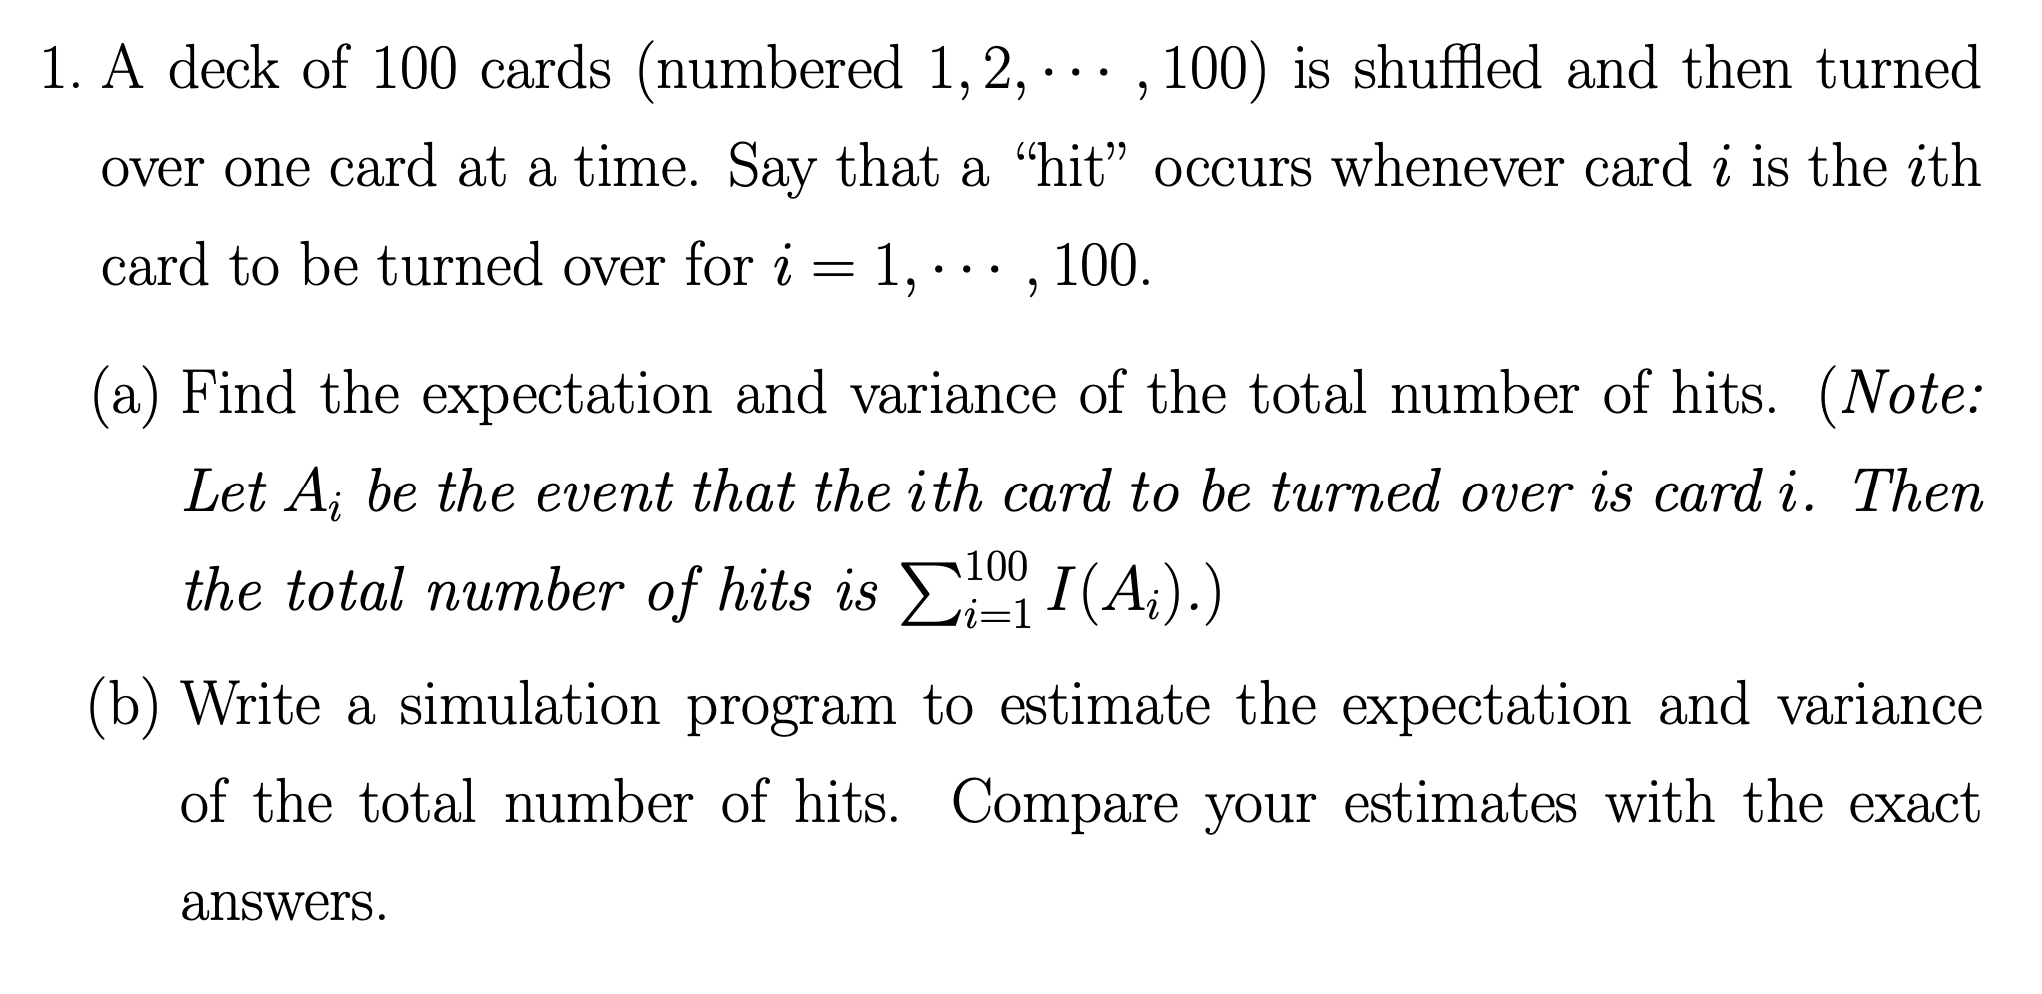

In [32]:
import random
import numpy as np

def simulate_hits(num_cards=100, num_rep=10_000):
    """
    重复 num_rep 次模拟：
      - 生成 [1..num_cards] 的随机排列
      - 统计 '命中' 数 hits：即有多少位置 i 的牌正好是 i
    返回 (hits的样本平均数, 样本方差)
    """
    all_hits = []
    for _ in range(num_rep):
        deck = list(range(1, num_cards+1))
        random.shuffle(deck)
        
        # 计算命中次数 X
        hits = 0
        for i, card in enumerate(deck, start=1):
            if card == i:
                hits += 1
        
        all_hits.append(hits)
    
    # 计算样本平均与样本方差（也可以自己用公式）
    mean_hits = np.mean(all_hits)
    var_hits  = np.var(all_hits)  #母方差，用pvariance
    
    return mean_hits, var_hits

# --------------- 主程序 ---------------
if __name__ == "__main__":
    N = 100
    REP = 20000  # 重复次数，可根据时间适当增大
    mean_est, var_est = simulate_hits(N, REP)
    
    print(f"After {REP} simulations for deck of {N} cards:")
    print(f"  Sample mean of hits = {mean_est:.4f}")
    print(f"  Sample variance of hits = {var_est:.4f}")
    
    # 与理论值比较
    print(f"  Theoretical expectation = 1.0")
    print(f"  Theoretical variance    = 1.0")

After 20000 simulations for deck of 100 cards:
  Sample mean of hits = 0.9987
  Sample variance of hits = 1.0039
  Theoretical expectation = 1.0
  Theoretical variance    = 1.0
